In [1]:
# need 'tables' package to read h5 files
#!conda install -c ska tables
!pip install tables
!pip install hdf5plugin
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 30.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 41.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 5.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=d79aef4a3e88c4021d4fba4f3aa95de0561de92c21c42792b30d8c0daa885987
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info


In [2]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import h5py, hdf5plugin
import scanpy as sc
import anndata as ad

from scipy.sparse import csr_matrix, vstack
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import gc, random


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/open-problems-multimodal/sample_submission.csv
/kaggle/input/open-problems-multimodal/train_cite_targets.h5
/kaggle/input/open-problems-multimodal/metadata_cite_day_2_donor_27678.csv
/kaggle/input/open-problems-multimodal/test_multi_inputs.h5
/kaggle/input/open-problems-multimodal/evaluation_ids.csv
/kaggle/input/open-problems-multimodal/train_cite_inputs.h5
/kaggle/input/open-problems-multimodal/train_multi_targets.h5
/kaggle/input/open-problems-multimodal/train_multi_inputs.h5
/kaggle/input/open-problems-multimodal/metadata.csv
/kaggle/input/open-problems-multimodal/test_cite_inputs_day_2_donor_27678.h5
/kaggle/input/open-problems-multimodal/test_cite_inputs.h5


In [3]:
# score function
# pearson correlation between predicted and actual values for each sample, 
# averaged over total samples

# scale of predictions not so important to competition host, 
# pearson correlation coefficient scoring chosen to de-emphasize scale

def corrscore(ypred, yactual):
    # numpy corrcoef uses array-like
    if type(ypred) == pd.DataFrame:
        ypred = ypred.values
    if type(yactual) == pd.DataFrame:
        yactual = yactual.values
    
    # dimensions must match
    if ypred.shape == yactual.shape:
        corrsum = 0
        for sample in range(len(yactual)):
            # get 2x2 correlation matrix, select off diagonal coeff, sum 
            corrsum += np.corrcoef(ypred[sample], yactual[sample])[0,1]
    else:
        print('ypred.shape != yactual.shape')
            
    return corrsum/len(yactual)
    

In [4]:
# file directory
dir = '../input/open-problems-multimodal/'

# file paths
metadata = dir + 'metadata.csv'
test_cite_inputs = dir + 'test_cite_inputs.h5'

train_cite_inputs = dir + 'train_cite_inputs.h5'
train_cite_targets = dir + 'train_cite_targets.h5'

In [5]:
# metadata file
metadf = pd.read_csv(metadata)
metadf.set_index('cell_id', drop=True, inplace=True)

In [6]:
# cite inputs - cell id x gene expression level
# already normalized (by library size) and log1p transformed

adatas = {} # dict to access adata objects

for filename in ['train_cite_inputs','test_cite_inputs']:

    # read h5 file
    with h5py.File(dir + filename + '.h5', 'r') as f:
        # print(f.keys())
        dataset = f[filename]
        # dataset.keys()

        # print(dataset['axis0'][0:5].astype(str)) # gene names --> features
        # print(dataset['axis1'][0:5]) # cell ids --> samples
        # print(dataset['block0_items'][0:5]) # gene names again
        # print(dataset['block0_values'][0:5]) # expression data

        # put data into anndata object for use with scanpy
        values = csr_matrix(dataset['block0_values'][:]) # sparse matrix to save space
        features = dataset['axis0'][:].astype(str) # gene features in 'ensembleid_genename' format
        samples = dataset['axis1'][:].astype(str) # cell ids

    adata = ad.AnnData(
        X=values,
        obs=metadf.loc[samples],
        var=pd.DataFrame(index=features)
    )
    # free memory
    values = None
    features = None 
    samples = None
        
    # add adata object to dict
    adatas[filename] = adata
    adata = None
    gc.collect()
    print(adatas[filename])
    


AnnData object with n_obs × n_vars = 70988 × 22050
    obs: 'day', 'donor', 'cell_type', 'technology'
AnnData object with n_obs × n_vars = 48663 × 22050
    obs: 'day', 'donor', 'cell_type', 'technology'


In [7]:
for filename in ['train_cite_inputs','test_cite_inputs']:
    print(filename)
    print(adatas[filename])
    print(adatas[filename].obs['technology'].unique())
    print(adatas[filename].obs.groupby('day')['donor'].value_counts())
    print()

train_cite_inputs
AnnData object with n_obs × n_vars = 70988 × 22050
    obs: 'day', 'donor', 'cell_type', 'technology'
['citeseq']
day  donor
2    31800     8395
     32606     7476
     13176     6071
3    13176     7643
     32606     6999
     31800     6259
4    31800    10149
     32606     9511
     13176     8485
Name: donor, dtype: int64

test_cite_inputs
AnnData object with n_obs × n_vars = 48663 × 22050
    obs: 'day', 'donor', 'cell_type', 'technology'
['citeseq']
day  donor
2    27678    7476
3    27678    6488
4    27678    7832
7    32606    7254
     13176    7195
     27678    6247
     31800    6171
Name: donor, dtype: int64



In [8]:
# load train target data
# already dsb normalized

with h5py.File(train_cite_targets, 'r') as targetf:
    targetdata = targetf['train_cite_targets']

    features = targetdata['axis0'][:].astype(str) # protein features
    samples = targetdata['axis1'][:].astype(str) # cell ids
    values = targetdata['block0_values'][:] # normalized protein expression values

targetdf = pd.DataFrame(values, index=samples, columns=features)

values = None
features = None 
samples = None
gc.collect()

targetdf.head()

,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


In [9]:
# # normalization caused some negative expression values in target
# # probably should change negative values to zero, but competition target won't have that modification
# targetdf.where(targetdf >= 0, other=0, inplace=True)
# targetdf.head()

In [10]:
# sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
for filename in ['train_cite_inputs','test_cite_inputs']:
    # isolate gene symbols from feature names
    featname_split = pd.DataFrame(list(adatas[filename].var_names.str.split('_')))

    # note mitochondrial genes, genes matching target proteins
    adatas[filename].var['mt'] = list(featname_split[1].str.startswith('MT-'))
    adatas[filename].var['intarget'] = list(featname_split[1].isin(targetdf.columns))
#     print(adatas[filename].var['mt'].sum())
#     print(adatas[filename].var[adatas[filename].var['mt']==True][:5])
#     print(adatas[filename].var['intarget'].sum())
#     print(adatas[filename].var[adatas[filename].var['intarget']==True][:5])
#     print(adatas[filename].var[:5])
    sc.pp.calculate_qc_metrics(adatas[filename], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#     print()

In [13]:
print('train_cite_inputs')
adatas['train_cite_inputs'].obs[:5]
    

train_cite_inputs


,day,donor,cell_type,technology,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
cell_id,,,,,,,,
45006fe3e4c8,2,32606,HSC,citeseq,3824,18104.832031,117.822098,0.650777
d02759a80ba2,2,32606,HSC,citeseq,3708,17467.492188,125.058868,0.715952
c016c6b0efa5,2,32606,EryP,citeseq,4612,20732.042969,131.589233,0.634714
ba7f733a4f75,2,32606,NeuP,citeseq,5881,25030.560547,133.151871,0.531957
fbcf2443ffb2,2,32606,EryP,citeseq,5841,25474.955078,115.825821,0.454665


In [14]:
print('test_cite_inputs')
adatas['test_cite_inputs'].obs[:5]
# known dataset issue, some train data duplicated in test set

test_cite_inputs


,day,donor,cell_type,technology,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
cell_id,,,,,,,,
c2150f55becb,2,27678,HSC,citeseq,3824,18104.832031,117.822098,0.650777
65b7edf8a4da,2,27678,HSC,citeseq,3708,17467.492188,125.058868,0.715952
c1b26cb1057b,2,27678,EryP,citeseq,4612,20732.042969,131.589233,0.634714
917168fa6f83,2,27678,NeuP,citeseq,5881,25030.560547,133.151871,0.531957
2b29feeca86d,2,27678,EryP,citeseq,5841,25474.955078,115.825821,0.454665


... storing 'cell_type' as categorical
... storing 'technology' as categorical


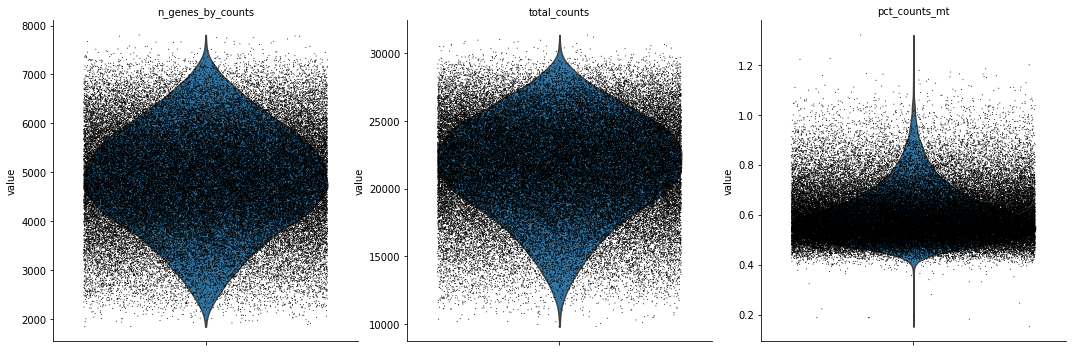

In [15]:
sc.pl.violin(adatas['train_cite_inputs'], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

... storing 'cell_type' as categorical
... storing 'technology' as categorical


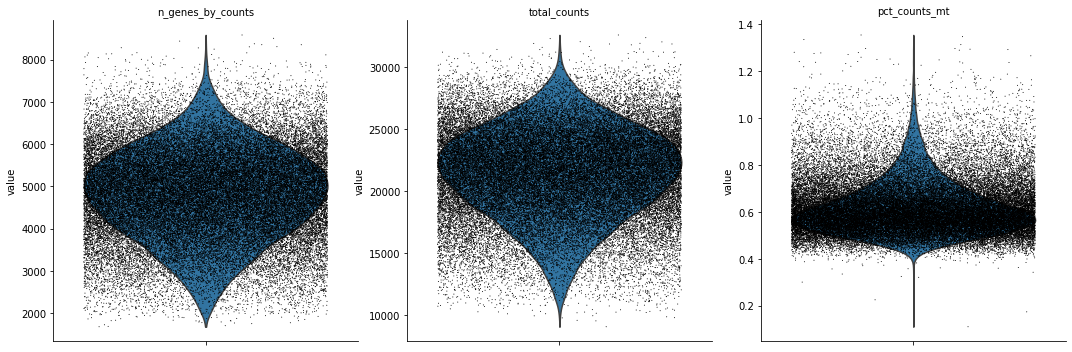

In [16]:
sc.pl.violin(adatas['test_cite_inputs'], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [17]:
# # filter out cells with < 0.3 or > 1.1 pct mt genes?
# sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

In [18]:
# test reducing features 
svd = TruncatedSVD(n_components=15, n_iter=7, random_state=765)
adatasvd = svd.fit_transform(adatas['train_cite_inputs'].X)
print(svd.explained_variance_ratio_)
print('sum: ', svd.explained_variance_ratio_.sum())
print(f"shape {adatas['train_cite_inputs'].shape} -> {adatasvd.shape}")
adatasvd = None
gc.collect()

[0.02764558 0.02171131 0.01394518 0.01052238 0.00827178 0.00524295
 0.00394385 0.00325871 0.002996   0.00221896 0.0020921  0.00178155
 0.00156838 0.00139721 0.0012755 ]
sum:  0.10787143
shape (70988, 22050) -> (70988, 15)


16782

In [19]:
# public test set contains data from donor not in train data
# private test set contains data from day not in train data

# group kfold: group by donor

gc.collect()

scorelist = []
scorelist2 = []
mse1list = []
mse2list = []

gkf = GroupKFold(n_splits=3)
dataset = adatas['train_cite_inputs'] 
groups = adatas['train_cite_inputs'].obs['donor']

for trainidx, testidx in gkf.split(dataset.X, groups=groups):
    trainx, trainy = dataset.X[trainidx], targetdf.reset_index(drop=True).loc[trainidx]
    testx, testy = dataset.X[testidx], targetdf.reset_index(drop=True).loc[testidx]
    
    print(f"test group is donor: {groups[testidx[0]]}")
    
    # feature reduction
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=765)
    trainx_svd = pd.DataFrame(svd.fit_transform(trainx))
    testx_svd = pd.DataFrame(svd.transform(testx))
    
    trainx_svd.columns = trainx_svd.columns.astype(str)
    testx_svd.columns = testx_svd.columns.astype(str)
    
    
    # create feature by clustering
    km = KMeans(n_clusters=10, random_state=765)
    trainx_svd['cluster'] = km.fit_predict(trainx_svd)
    testx_svd['cluster'] = km.predict(testx_svd)

    
    # add 'day' feature from metadata
    trainx_svd['day'] = list(dataset.obs['day'].reset_index(drop=True).loc[trainidx])
    testx_svd['day'] = list(dataset.obs['day'].reset_index(drop=True).loc[testidx])
    
    
    # ridge regression model
    ridgepipe = Pipeline([
        ('rscaler', RobustScaler()),
        ('ridge', Ridge())
    ])
    
    ridgepipe.fit(trainx_svd, trainy)
    predy = ridgepipe.predict(testx_svd)
    
    # xgboost model
    xgb = XGBRegressor(n_estimators=50, max_depth=5, tree_method='hist')
    multixgb = MultiOutputRegressor(xgb)

    multixgb.fit(trainx_svd, trainy)
    predy2 = multixgb.predict(testx_svd)

    # ensemble prediction
    predy12 = 0.35*(predy) + 0.65*(predy2)
    predy122 = 0.3*(predy) + 0.7*(predy2)

    # store scores
    scorelist.append(corrscore(predy12, testy))
    scorelist2.append(corrscore(predy122, testy))
    mse1list.append(mean_squared_error(testy, predy))
    mse2list.append(mean_squared_error(testy, predy2))
    
    

print(f'mean corr score: {np.mean(scorelist)}, scores: {scorelist}')
print(f'mean corr score: {np.mean(scorelist2)}, scores: {scorelist2}')
print(f'mean mse ridge: {np.mean(mse1list)}, scores: {mse1list}')
print(f'mean mse xgb: {np.mean(mse2list)}, scores: {mse2list}')



test group is donor: 31800
test group is donor: 32606
test group is donor: 13176
mean corr score: 0.8841542680656413, scores: [0.8810035504524174, 0.8872450311823853, 0.8842142225621211]
mean corr score: 0.8838334468556317, scores: [0.8806156288306743, 0.8868969764466587, 0.883987735289562]
mean mse ridge: 3.2503156892256677, scores: [2.606296034380655, 2.5829005105764553, 4.561750522719892]
mean mse xgb: 3.294598340988159, scores: [2.7086468, 2.563396, 4.6117525]


In [21]:
%%time
# how long does xgb take?
xgb = XGBRegressor(n_estimators=50, max_depth=5, tree_method='hist')
multixgb = MultiOutputRegressor(xgb)

multixgb.fit(trainx_svd, trainy)
predy2 = multixgb.predict(testx_svd)
print(f'corr score: {corrscore(predy2, testy)}')
multixgb.score(testx_svd, testy)

corr score: 0.8813515443404266
CPU times: user 18min 23s, sys: 1.44 s, total: 18min 25s
Wall time: 4min 48s


-0.05145962133149019

In [22]:
# group data for predicting values from day outside of training set range
# slice adata into train and test
dataset = adatas['train_cite_inputs']

# train set is days 2 and 3
trainset = dataset[~(dataset.obs['day']==4)]
print(trainset.shape)
traintarg = targetdf.loc[list(trainset.obs_names)]
print(traintarg.shape)

# test set is only day 4 (simulate predicting out-of-sample day 7 of actual test set)
testset = dataset[dataset.obs['day']==4]
print(testset.shape)
testtarg = targetdf.loc[list(testset.obs_names)]
print(testtarg.shape)
testtarg.head()

(42843, 22050)
(42843, 140)
(28145, 22050)
(28145, 140)


,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
23c7ea3e83df,-0.038837,0.345492,1.575431,4.901691,3.490050,5.520907,0.269050,0.103832,0.429251,-0.737670,...,1.461037,5.754700,1.559128,0.602265,0.064853,0.236033,5.867673,0.661419,5.509303,2.461890
07545a7f7724,0.581632,-0.781041,2.654096,7.524086,6.104551,5.848989,-0.764493,1.348626,0.948382,-0.758954,...,-0.146351,7.441052,1.859274,0.914807,-0.293588,1.700874,8.789862,1.162518,5.320499,4.521204
d25f4e18b7af,1.678051,0.319266,0.771224,5.023542,8.098757,10.714052,4.236963,-0.342571,0.354417,1.202587,...,1.058050,6.571698,0.117781,0.719630,-0.250392,0.958905,3.177387,0.053333,2.255179,0.557725
b86ecca69c3d,0.345989,0.167182,-0.019650,1.714670,5.182465,7.930543,2.550410,0.302015,0.631652,-0.505521,...,0.514281,8.401997,0.114058,0.234194,-0.458291,0.351295,4.961888,0.285926,2.039783,-0.106655
531e4381efe7,1.031650,-0.109810,-0.191206,5.819048,4.056424,3.213348,4.925136,-1.068914,-1.458058,1.237933,...,-0.547198,5.728522,0.666205,-1.320433,0.020952,0.446819,5.365129,-0.154721,2.616540,1.303230


In [23]:
trainx_svd = None
testx_svd = None
km = None
multixgb = None
gc.collect()

# filter out genes expressed in fewer than x% of cells
print(f'trainset before {trainset.shape}')
sc.pp.filter_genes(trainset, min_cells=0.001*trainset.shape[0])
print(f'trainset after {trainset.shape}')
retainedfeat = trainset.var_names.tolist()
testset = testset[:,retainedfeat]
print(f'testset after {testset.shape}')

# # note mitochondrial genes, genes matching target proteins
# featname_split = pd.DataFrame(list(trainset.var_names.str.split('_')))
# trainset.var['mt'] = list(featname_split[1].str.startswith('MT-'))
# trainset.var['intarget'] = list(featname_split[1].isin(targetdf.columns))
# sc.pp.calculate_qc_metrics(trainset, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# # drop samples from train set based on mt pct
# trainset = trainset[(trainset.obs['pct_counts_mt']>0.3) & (trainset.obs['pct_counts_mt']<1.1)]
# print(f'shape after mt filter {trainset.shape}')
# traintarg = traintarg.loc[trainset.obs_names.tolist()]
# print(f'target shape after mt filter {traintarg.shape}')

# feature reduction
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=765)
trainx_svd = pd.DataFrame(svd.fit_transform(trainset.X))
testx_svd = pd.DataFrame(svd.transform(testset.X))

trainx_svd.columns = trainx_svd.columns.astype(str)
testx_svd.columns = testx_svd.columns.astype(str)


# create feature by clustering
km = KMeans(n_clusters=10, random_state=765)
trainx_svd['cluster'] = km.fit_predict(trainx_svd)
testx_svd['cluster'] = km.predict(testx_svd)


# add 'day' feature from metadata
trainx_svd['day'] = list(trainset.obs['day'])
testx_svd['day'] = list(testset.obs['day'])


# ridge regression model
ridgepipe = Pipeline([
    ('rscaler', RobustScaler()),
    ('ridge', Ridge())
])

ridgepipe.fit(trainx_svd, traintarg)
predy = ridgepipe.predict(testx_svd)


# xgboost model
xgb = XGBRegressor(n_estimators=50, max_depth=5, tree_method='hist')
multixgb = MultiOutputRegressor(xgb)

multixgb.fit(trainx_svd, traintarg)
predy2 = multixgb.predict(testx_svd)


# ensemble prediction
predy12 = 0.5*(predy) + 0.5*(predy2)
predy122 = 0.3*(predy) + 0.7*(predy2)

# store scores
score = corrscore(predy12, testtarg)
score2 = corrscore(predy122, testtarg)
mse1 = mean_squared_error(testtarg, predy)
mse2 = mean_squared_error(testtarg, predy2)



print(f'mean corr score: {score}')
print(f'mean corr score: {score2}')
print(f'mean mse ridge: {mse1}')
print(f'mean mse xgb: {mse2}')



trainset before (42843, 22050)


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


trainset after (42843, 20024)
testset after (28145, 20024)
mean corr score: 0.879033226701492
mean corr score: 0.8805796763619621
mean mse ridge: 2.9624572637435986
mean mse xgb: 2.783378839492798
